In [1]:
# testing balanced strategy on 2-dimensional input canonical problem
# -PIONEER
# Author: Alex Braafladt
# Created 3/16/23
#

In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from botorch import fit_gpytorch_mll

from extremasearch.local.ndlocalsearch import NdLocalSearchState, NdLocalExtremeSearch
from extremasearch.globalmm.ndglobalsearch import MultimodalExtremaSearch

# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# setup file i/o
import os as os
import datetime as dt
# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'mme_balanced_nd' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks
Data save directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks\output\\mme_balanced_nd20230317000056


C:\Users\alexb\PycharmProjects\extrema_search\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


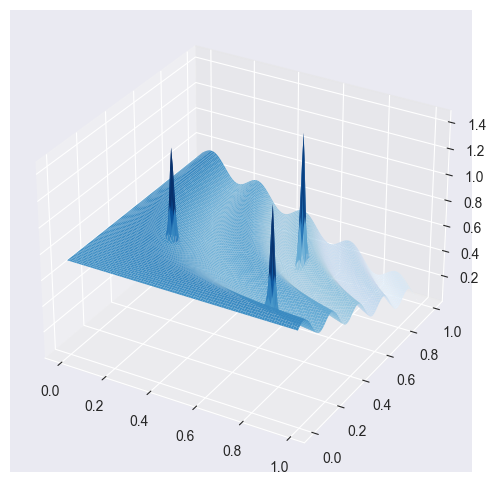

In [4]:
# and with addition of smooth global behavior
def mme_add_2d_plot(x1, x2):
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = mme_add_2d_plot(X1, X2)
from matplotlib import ticker, cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(Z.numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
plt.savefig(datasavedir + '/'+'2d_mme_attempt'+'.png')

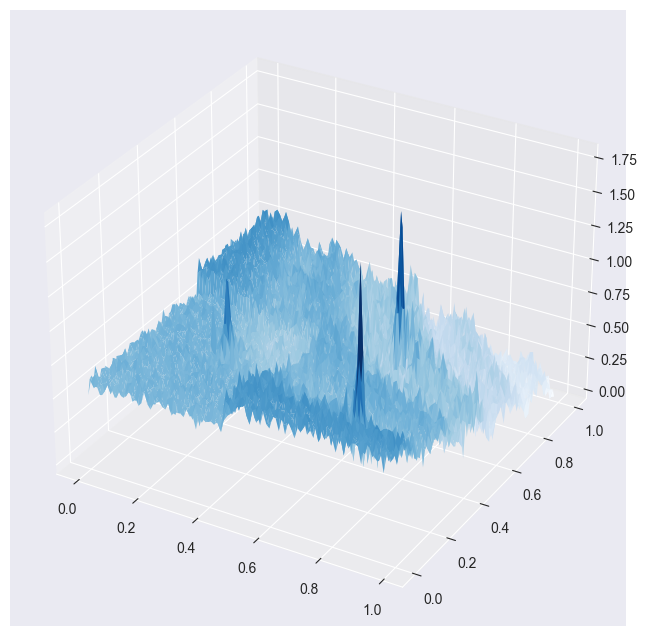

In [5]:
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
plt.savefig(datasavedir + '/'+'2d_mme_noise_attempt1'+'.png')

In [6]:
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [7]:
test_nd_global_search = MultimodalExtremaSearch(obj_func=outcome_objective, input_dim=2,
                                                tead_model_type='piecewise',
                                                total_iteration_limit=400)

In [8]:
test_nd_global_search.run_global_search()

Setting up global state
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.1796, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.1795995629694163
Running partition
PARTITION: Splitting node  0  from  tensor([[0., 0.],
        [1., 1.]], dtype=torch.float64)  to  tensor([[0.0000, 0.0000],
        [0.5000, 1.0000]], dtype=torch.float64)  and  tensor([[0.5000, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  tensor([[0.0121, 0.0009]],

In [9]:
g = test_nd_global_search.global_state.partition_graph

In [10]:
# functions for getting and working with data from searches
def get_bounds(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    bound_list = []
    node_list = []
    for n in graph_leaves:
        # get current leaf node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list

In [11]:
leaf_nodes, leaf_bounds = get_bounds(g)

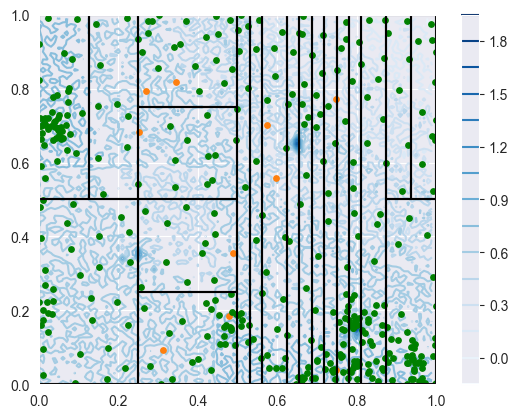

In [12]:
x_plot = test_nd_global_search.global_state.x_global

fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)
ax1.scatter(x_plot[:,0].numpy()[0:10], x_plot[:,1].numpy()[0:10], s=15, marker='o', color='tab:orange', zorder=2)
ax1.scatter(x_plot[:,0].numpy()[10:], x_plot[:,1].numpy()[10:], s=15, marker='o', color='g', zorder=2)
for i in range(len(leaf_bounds)):
    ax1.plot([leaf_bounds[i][0,0], leaf_bounds[i][1,0]], [leaf_bounds[i][0,1], leaf_bounds[i][0,1]], color='k')
    ax1.plot([leaf_bounds[i][1,0], leaf_bounds[i][1,0]], [leaf_bounds[i][0,1], leaf_bounds[i][1,1]], color='k')
    ax1.plot([leaf_bounds[i][1,0], leaf_bounds[i][0,0]], [leaf_bounds[i][1,1], leaf_bounds[i][1,1]], color='k')
    ax1.plot([leaf_bounds[i][0,0], leaf_bounds[i][0,0]], [leaf_bounds[i][1,1], leaf_bounds[i][0,1]], color='k')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
plt.savefig(datasavedir + '/'+'2d_mme_noise_turbo_evals_contour'+'.png')

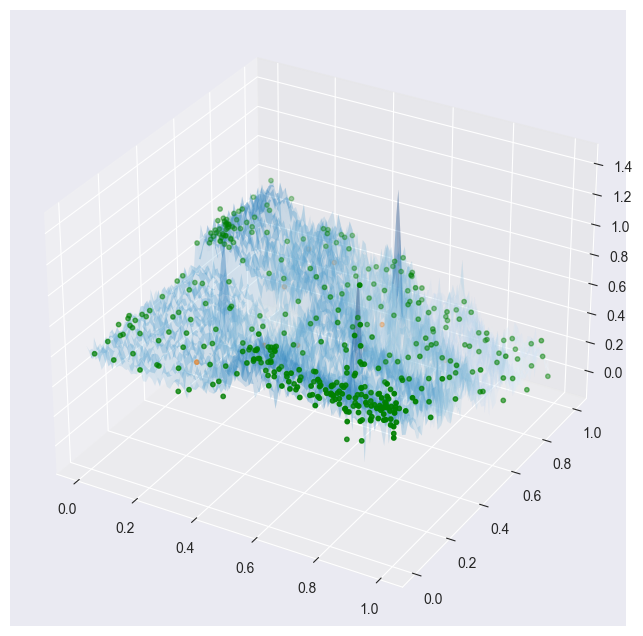

In [13]:
# plot evaluations for turbo - surface
y_plot = test_nd_global_search.global_state.y_global


x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(x_plot[:,0].numpy()[0:10], x_plot[:,1].numpy()[0:10], y_plot.numpy()[0:10], marker='.', color='tab:orange', s=40)
ax.scatter(x_plot[:,0].numpy()[10:], x_plot[:,1].numpy()[10:], y_plot.numpy()[10:], marker='.', color='g', s=40)
plt.savefig(datasavedir + '/'+'2d_mme_noise_turbo_evals'+'.png')

In [16]:
# metrics functions
def count_number_peaks_observed_2d(x_obs, y_obs, num_known_peaks=3):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3 = False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.64 <= x[0] <= 0.66 and 0.64 <= x[1] <= 0.66:
            if y >= 1.37:
                peak1 = True
        elif 0.24 <= x[0] <= 0.26 and 0.34 <= x[1] <= 0.36:
            if y >= 1.06:
                peak2 = True
        elif 0.79 <= x[0] <= 0.81 and 0.14 <= x[1] <= 0.16:
            if y >= 1.36:
                peak3 = True
    num_peaks_observed = peak1 + peak2 + peak3
    return num_peaks_observed


def count_evaluations_for_all_peaks_2d(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3 = False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.64 <= x[0] <= 0.66 and 0.64 <= x[1] <= 0.66:
            if y >= 1.37:
                peak1 = True
        elif 0.24 <= x[0] <= 0.26 and 0.34 <= x[1] <= 0.36:
            if y >= 1.06:
                peak2 = True
        elif 0.79 <= x[0] <= 0.81 and 0.14 <= x[1] <= 0.16:
            if y >= 1.36:
                peak3 = True
        i += 1
        if peak1 and peak2 and peak3:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks

In [17]:
# calculate summary metrics
# calculate metrics
distinct_peaks = []
function_evaluations = []
n_replications = 1
num_peaks_observed = count_number_peaks_observed_2d(test_nd_global_search.global_state.x_global,
                                                 test_nd_global_search.global_state.y_global)
print("Observed {num:} peaks".format(num=num_peaks_observed),)
distinct_peaks.append(num_peaks_observed)
fe = count_evaluations_for_all_peaks_2d(test_nd_global_search.global_state.x_global,
                                     test_nd_global_search.global_state.y_global)
print("Function evaluations to find all peaks: {}".format(fe))
function_evaluations.append(fe)
# peak ratio
num_known_peaks = 3
# n_replications = 15
peak_ratio = sum(distinct_peaks) / (num_known_peaks * n_replications)
print("Peak ratio: {}".format(peak_ratio))
# success rate
num_successes = 0
for i in range(n_replications):
    if distinct_peaks[i] == 3:
        num_successes += 1
success_ratio = num_successes / n_replications
print("Success ratio: {}".format(success_ratio))
print("Average function evaluations: {}".format(sum(function_evaluations) / n_replications))

Observed 0 peaks
Function evaluations to find all peaks: 401
Peak ratio: 0.0
Success ratio: 0.0
Average function evaluations: 401.0


In [26]:
import networkx as nx
def get_bounds_all(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_nodes = [n for n in graph]
    bound_list = []
    node_list = []
    for n in graph_nodes:
        # get current node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list

def plot_current_tree(global_search: MultimodalExtremaSearch, rep):
    """Save a plot of the tree structure after the search"""
    # tree figure
    T = global_search.global_state.partition_graph
    pos = nx.nx_agraph.graphviz_layout(T, prog="dot")
    # bounds to put on nodes on plot
    all_nodes, all_bounds = get_bounds_all(global_search.global_state.partition_graph)
    # positioning of bound text
    pos_attrs = {}
    for node, coords in pos.items():
        pos_attrs[node] = (coords[0]-35, coords[1]-5)
    custom_node_attrs = {}
    for node, attrs in zip(all_nodes, all_bounds):
        custom_node_attrs[node] = str(attrs.numpy().round(decimals=3))
    # plot commands
    f, ax = plt.subplots(1, 1, figsize=(20, 8), constrained_layout=True)
    nx.draw(T, pos, with_labels=True, font_weight='bold', ax=ax)
    nx.draw_networkx_labels(T, pos_attrs, labels=custom_node_attrs, ax=ax)
    ax.set_title('PIONEER Partition Tree')
    plt.savefig(datasavedir + '/'+'partition_tree_rep{}'.format(rep)+'.png')

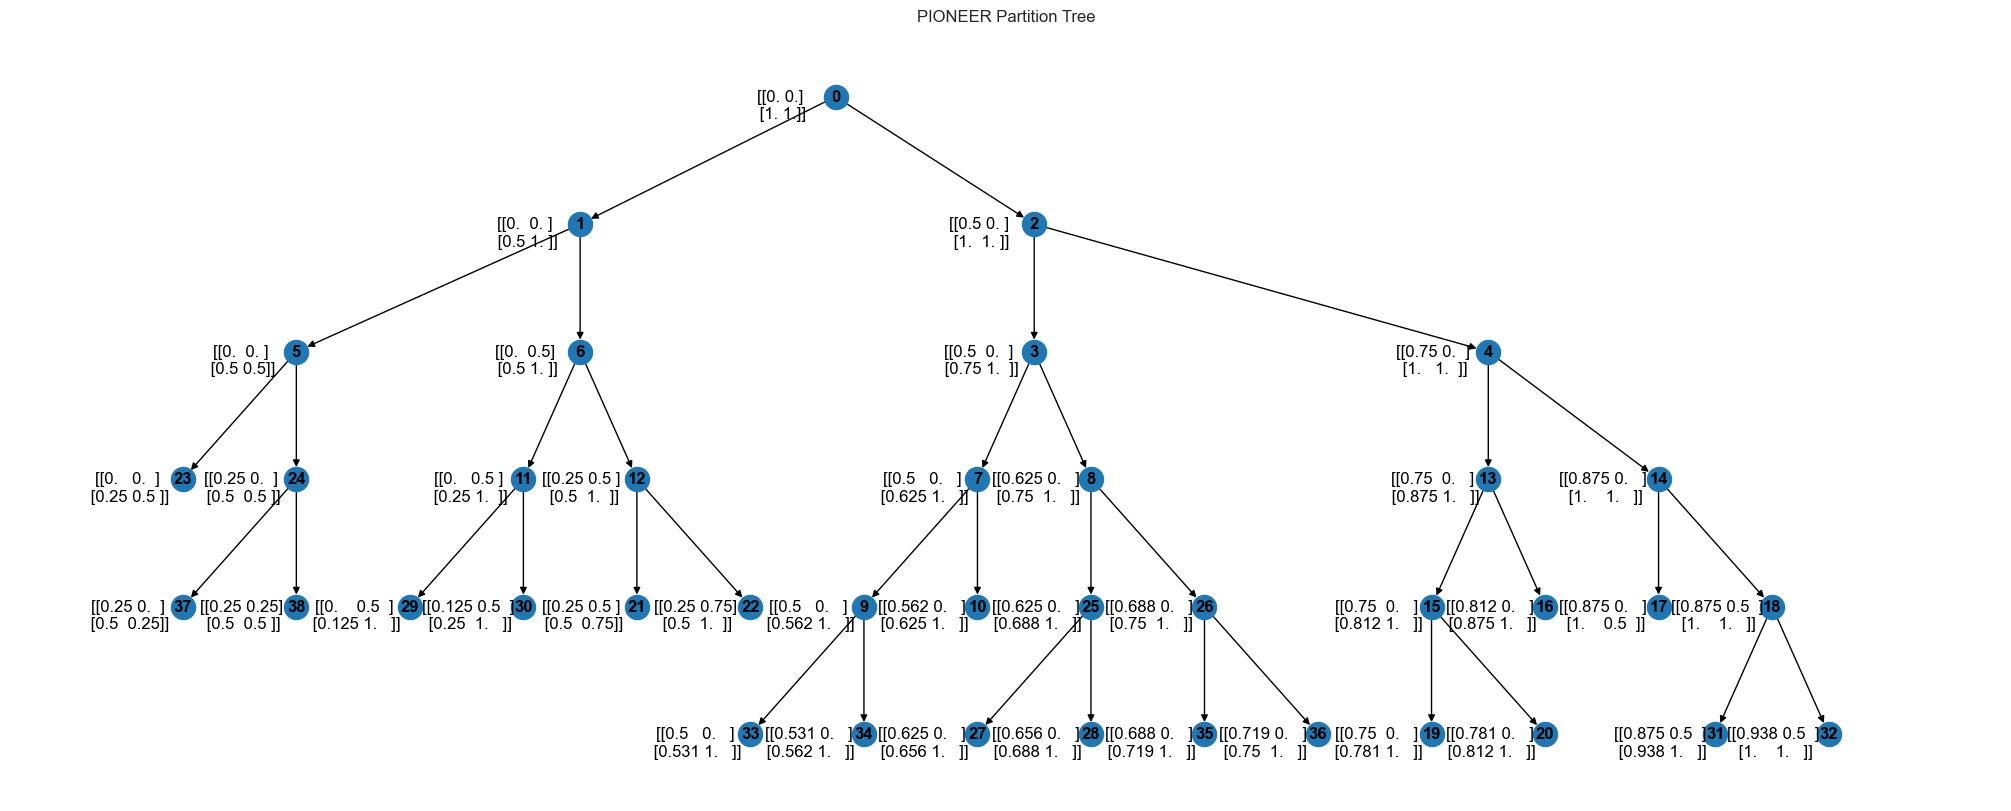

In [27]:
plot_current_tree(test_nd_global_search, 0)